# Class Activity # 5 (DL)

## Deep Learning for Sequences using RNN

**Department of Computer Science**  
**DS5118-Deep Learning, Fall 2025**  
**December 14, 2025**

---

This notebook focuses on implementing deep learning models for sequence data, specifically stock price prediction, using RNNs, 1D Convolutions, and hybrid models.


In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings("ignore")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.19.0


---

## Task 1: Understanding Sequential Data

- Load and explore the AAPL stock price dataset
- Visualize the time series data (closing prices)
- Reverse the data for chronological order and plot again
- Extract and reshape the closing price values for modeling


In [2]:
# Load AAPL stock price data
# Using yfinance to download data (install with: pip install yfinance)
try:
    import yfinance as yf

    aapl = yf.download("AAPL", start="2015-01-01", end="2024-01-01", progress=False)
    aapl.to_csv("AAPL.csv")
    print("Data downloaded successfully from Yahoo Finance")
except:
    # If yfinance not available, try loading from CSV
    aapl = pd.read_csv("AAPL.csv", index_col="Date", parse_dates=True)
    print("Data loaded from CSV file")

# Display basic information about the dataset
print(f"\nDataset Shape: {aapl.shape}")
print(f"\nFirst 5 rows:")
aapl.head()

Data downloaded successfully from Yahoo Finance

Dataset Shape: (2264, 5)

First 5 rows:


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2015-01-02,24.237556,24.705326,23.798606,24.694241,212818400
2015-01-05,23.554737,24.086797,23.368517,24.006988,257142000
2015-01-06,23.556957,23.816336,23.195599,23.619031,263188400
2015-01-07,23.887281,23.987042,23.654504,23.765350,160423600
2015-01-08,24.805080,24.862721,24.097883,24.215381,237458000


In [3]:
# Explore the dataset
print("Dataset Info:")
print(aapl.info())
print("\nStatistical Summary:")
aapl.describe()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2264 entries, 2015-01-02 to 2023-12-29
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AAPL)   2264 non-null   float64
 1   (High, AAPL)    2264 non-null   float64
 2   (Low, AAPL)     2264 non-null   float64
 3   (Open, AAPL)    2264 non-null   float64
 4   (Volume, AAPL)  2264 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 106.1 KB
None

Statistical Summary:


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
count,2264.000000,2264.000000,2264.000000,2264.000000,2.264000e+03
mean,81.394710,82.219238,80.488207,81.326289,1.237614e+08
std,55.990879,56.564198,55.355885,55.936225,6.818417e+07
min,20.604080,20.907416,20.405658,20.526535,2.404830e+07
25%,32.814696,33.010875,32.633559,32.826850,7.831732e+07
50%,51.220846,52.032154,50.846578,51.367712,1.056556e+08
75%,139.017632,140.703831,136.516763,138.959189,1.486811e+08
max,196.256592,197.752460,195.156959,196.167437,6.488252e+08


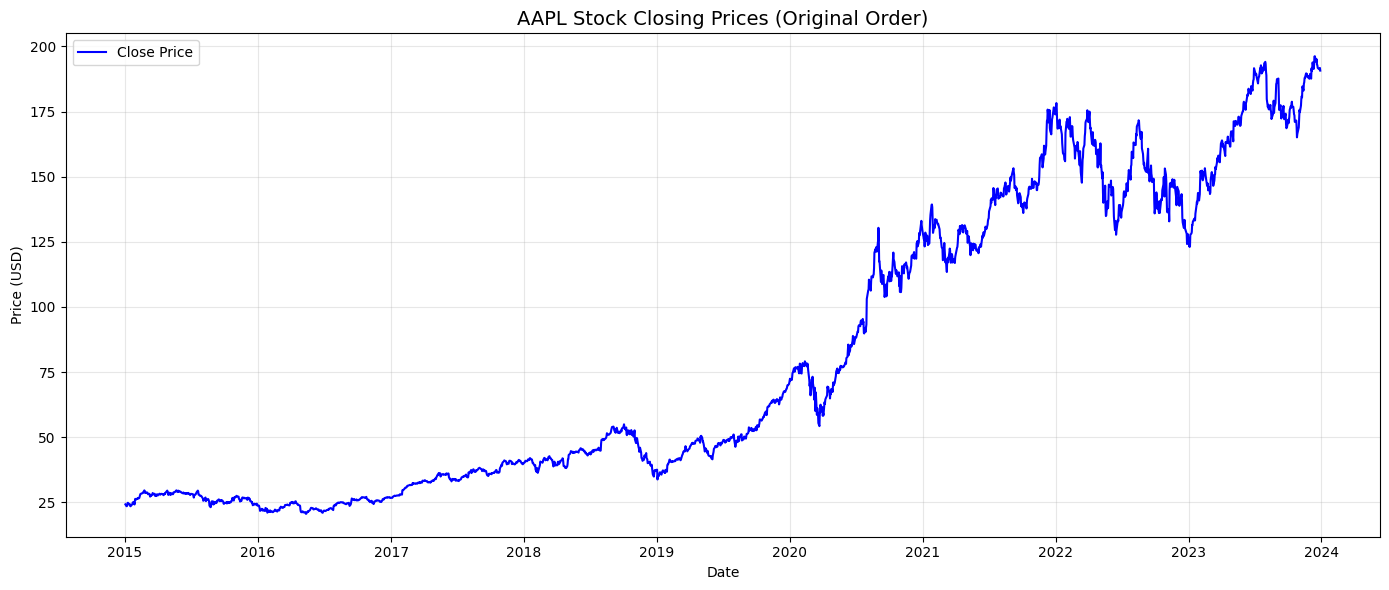

In [4]:
# Visualize the time series data (closing prices)
plt.figure(figsize=(14, 6))
plt.plot(aapl["Close"], label="Close Price", color="blue")
plt.title("AAPL Stock Closing Prices (Original Order)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

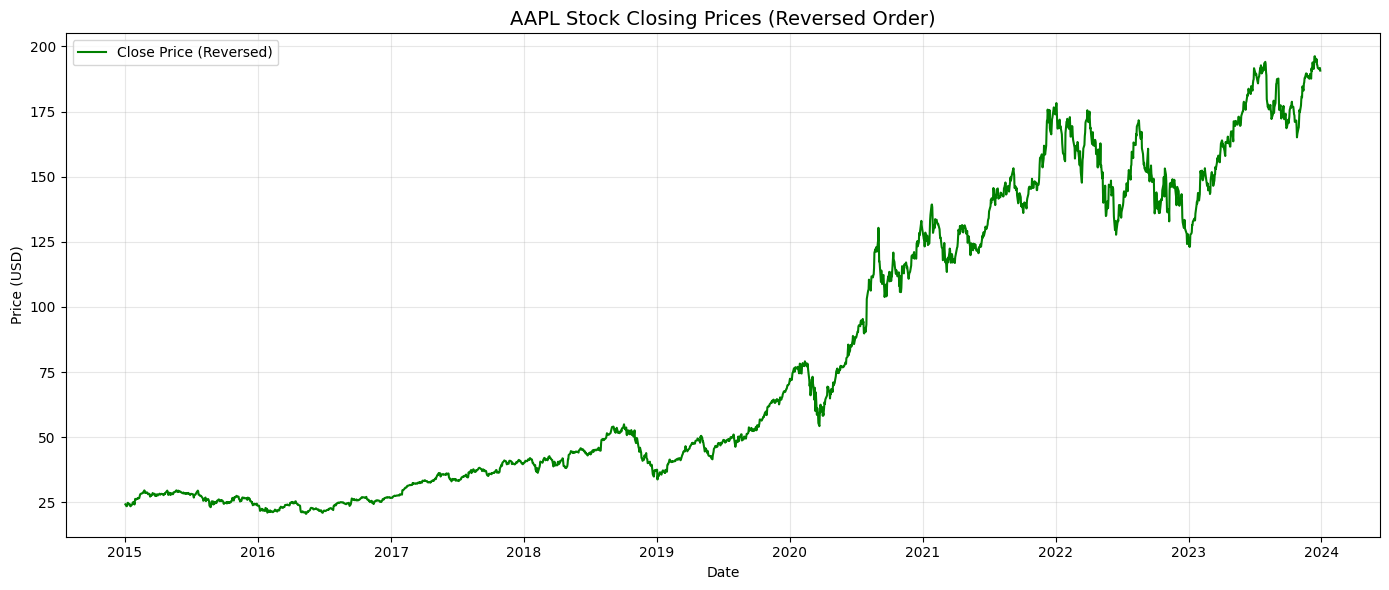


Using original chronological order for modeling.


In [5]:
# Reverse the data for chronological order (if needed) and plot again
# Note: Yahoo Finance data is typically already in chronological order (oldest first)
# But if it was in reverse order, we would do:
aapl_reversed = aapl.iloc[::-1]  # Reverse the dataframe

plt.figure(figsize=(14, 6))
plt.plot(aapl_reversed["Close"], label="Close Price (Reversed)", color="green")
plt.title("AAPL Stock Closing Prices (Reversed Order)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Use original chronological order for modeling
print("\nUsing original chronological order for modeling.")

In [7]:
# Extract and reshape the closing price values for modeling
close_prices = aapl["Close"].values.reshape(-1, 1)
print(f"Shape of closing prices: {close_prices.shape}")
print(f"First 10 values:\n{close_prices[:10].flatten()}")

Shape of closing prices: (2264, 1)
First 10 values:
[24.23755646 23.55473709 23.55695724 23.88728142 24.80508041 24.83168602
 24.21982002 24.4348526  24.34174919 23.68110275]


---

## Task 2: Implementing a Simple RNN Forward Pass

- Implement a forward pass for a simple RNN with two time steps using TensorFlow
- Define feedforward and recurrent weight matrices
- Compute hidden states at t=0 and t=1 using tanh activation
- Print and interpret the outputs


In [8]:
# Implementing a simple RNN forward pass from scratch

# Define parameters
input_size = 2  # Input dimension
hidden_size = 3  # Hidden state dimension

# Initialize weight matrices
np.random.seed(42)

# Weight matrix for input to hidden (W_xh)
W_xh = tf.Variable(
    np.random.randn(input_size, hidden_size).astype(np.float32), name="W_xh"
)

# Weight matrix for hidden to hidden (recurrent) (W_hh)
W_hh = tf.Variable(
    np.random.randn(hidden_size, hidden_size).astype(np.float32), name="W_hh"
)

# Bias for hidden layer
b_h = tf.Variable(np.zeros(hidden_size).astype(np.float32), name="b_h")

print("Weight matrices:")
print(f"\nW_xh (input to hidden) shape: {W_xh.shape}")
print(W_xh.numpy())
print(f"\nW_hh (hidden to hidden) shape: {W_hh.shape}")
print(W_hh.numpy())
print(f"\nb_h (bias) shape: {b_h.shape}")
print(b_h.numpy())

Weight matrices:

W_xh (input to hidden) shape: (2, 3)
[[ 0.49671414 -0.1382643   0.64768857]
 [ 1.5230298  -0.23415338 -0.23413695]]

W_hh (hidden to hidden) shape: (3, 3)
[[ 1.5792128   0.7674347  -0.46947438]
 [ 0.54256004 -0.46341768 -0.46572974]
 [ 0.24196227 -1.9132802  -1.7249179 ]]

b_h (bias) shape: (3,)
[0. 0. 0.]


In [9]:
# Define input sequence (2 time steps, each with 2 features)
x = tf.constant(
    [[1.0, 2.0], [0.5, 1.5]], dtype=tf.float32  # Input at t=0
)  # Input at t=1

print("Input sequence:")
print(x.numpy())

# Initialize hidden state at t=-1 (before the sequence starts)
h_prev = tf.zeros([hidden_size], dtype=tf.float32)
print(f"\nInitial hidden state h(-1): {h_prev.numpy()}")

Input sequence:
[[1.  2. ]
 [0.5 1.5]]

Initial hidden state h(-1): [0. 0. 0.]


In [10]:
# Compute hidden states at each time step

# Time step t=0
x_t0 = x[0]  # Input at t=0
# h(0) = tanh(x(0) * W_xh + h(-1) * W_hh + b_h)
h_t0 = tf.nn.tanh(
    tf.matmul(tf.reshape(x_t0, [1, -1]), W_xh)
    + tf.matmul(tf.reshape(h_prev, [1, -1]), W_hh)
    + b_h
)
h_t0 = tf.squeeze(h_t0)

print("Time step t=0:")
print(f"  Input x(0): {x_t0.numpy()}")
print(f"  Previous hidden state h(-1): {h_prev.numpy()}")
print(f"  New hidden state h(0): {h_t0.numpy()}")

# Time step t=1
x_t1 = x[1]  # Input at t=1
# h(1) = tanh(x(1) * W_xh + h(0) * W_hh + b_h)
h_t1 = tf.nn.tanh(
    tf.matmul(tf.reshape(x_t1, [1, -1]), W_xh)
    + tf.matmul(tf.reshape(h_t0, [1, -1]), W_hh)
    + b_h
)
h_t1 = tf.squeeze(h_t1)

print("\nTime step t=1:")
print(f"  Input x(1): {x_t1.numpy()}")
print(f"  Previous hidden state h(0): {h_t0.numpy()}")
print(f"  New hidden state h(1): {h_t1.numpy()}")

Time step t=0:
  Input x(0): [1. 2.]
  Previous hidden state h(-1): [0. 0. 0.]
  New hidden state h(0): [ 0.99832714 -0.5417089   0.17751403]

Time step t=1:
  Input x(1): [0.5 1.5]
  Previous hidden state h(0): [ 0.99832714 -0.5417089   0.17751403]
  New hidden state h(1): [ 0.99911     0.25166726 -0.5004882 ]


In [11]:
# Interpretation of the outputs
print("=" * 60)
print("INTERPRETATION OF RNN FORWARD PASS")
print("=" * 60)
print(
    """
1. At each time step, the RNN computes a new hidden state based on:
   - The current input (x_t)
   - The previous hidden state (h_{t-1})
   
2. The formula used is: h_t = tanh(x_t * W_xh + h_{t-1} * W_hh + b)

3. The tanh activation squashes values to the range [-1, 1],
   helping to maintain stable gradients during training.

4. The hidden state h_t captures information from the current
   input and all previous inputs in the sequence.

5. This "memory" effect is what makes RNNs suitable for
   sequential data like time series and natural language.
"""
)

# Verify with Keras SimpleRNN
print("\nVerification using Keras SimpleRNN:")
simple_rnn = layers.SimpleRNN(hidden_size, return_sequences=True, activation="tanh")
# Reshape input for RNN: (batch_size, time_steps, features)
x_keras = tf.reshape(x, [1, 2, 2])
keras_output = simple_rnn(x_keras)
print(f"Keras SimpleRNN output shape: {keras_output.shape}")
print(f"Keras output (all time steps):\n{keras_output.numpy()}")

INTERPRETATION OF RNN FORWARD PASS

1. At each time step, the RNN computes a new hidden state based on:
   - The current input (x_t)
   - The previous hidden state (h_{t-1})
   
2. The formula used is: h_t = tanh(x_t * W_xh + h_{t-1} * W_hh + b)

3. The tanh activation squashes values to the range [-1, 1],
   helping to maintain stable gradients during training.

4. The hidden state h_t captures information from the current
   input and all previous inputs in the sequence.

5. This "memory" effect is what makes RNNs suitable for
   sequential data like time series and natural language.


Verification using Keras SimpleRNN:
Keras SimpleRNN output shape: (1, 2, 3)
Keras output (all time steps):
[[[ 0.98285884 -0.9791727  -0.46155795]
  [ 0.80753845 -0.737901    0.5023413 ]]]


---

## Task 3: Building a Plain RNN Model with Keras

- Build a Sequential model with Reshape, SimpleRNN, and Dense layers
- Compile with mean squared error loss and adam optimizer
- Train on scaled stock price data with a lookback period of 10
- Evaluate using RMSE and visualize predictions


In [12]:
# Prepare data for the RNN model
def create_sequences(data, lookback):
    """
    Create sequences for time series prediction.

    Args:
        data: numpy array of shape (n_samples, 1)
        lookback: number of time steps to look back

    Returns:
        X: sequences of shape (n_samples - lookback, lookback, 1)
        y: targets of shape (n_samples - lookback, 1)
    """
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i : i + lookback])
        y.append(data[i + lookback])
    return np.array(X), np.array(y)


# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

# Define lookback period
lookback = 10

# Create sequences
X, y = create_sequences(scaled_data, lookback)

# Split into train and test sets (80/20)
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"Lookback period: {lookback}")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

Lookback period: 10
X_train shape: (1803, 10, 1)
y_train shape: (1803, 1)
X_test shape: (451, 10, 1)
y_test shape: (451, 1)


In [13]:
# Build the Plain RNN Model
rnn_model = keras.Sequential(
    [
        layers.Reshape((lookback, 1), input_shape=(lookback, 1)),
        layers.SimpleRNN(32, activation="tanh"),
        layers.Dense(1, activation="linear"),
    ],
    name="Plain_RNN_Model",
)

# Compile the model
rnn_model.compile(optimizer="adam", loss="mse")

# Model summary
rnn_model.summary()

Model: "Plain_RNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 10, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 32)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,121 (4.38 KB)

 Trainable params: 1,121 (4.38 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Train the RNN model
history_rnn = rnn_model.fit(
    X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1
)

Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0020 - val_loss: 0.0132
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4209e-04 - val_loss: 0.0043
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4274e-04 - val_loss: 0.0012
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.4756e-04 - val_loss: 0.0010
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2747e-04 - val_loss: 0.0010
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0367e-04 - val_loss: 8.1687e-04
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.8319e-05 - val_loss: 7.6444e-04
Epoch 8/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.0536e-05 - val_loss: 6.9867e-04
Epoch 9/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.5049e-05 - val_loss: 6.4870e-04
Epoch 10/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.0410e-05 - val_loss: 6.0589e-04
Epoch 11/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.6545e-05 - val_loss: 5.7001e-04
Epoch 12

In [15]:
# Evaluate the RNN model
y_pred_rnn = rnn_model.predict(X_test)

# Inverse transform to get actual prices
y_test_actual = scaler.inverse_transform(y_test)
y_pred_rnn_actual = scaler.inverse_transform(y_pred_rnn)

# Calculate RMSE
rmse_rnn = np.sqrt(mean_squared_error(y_test_actual, y_pred_rnn_actual))
print(f"\nPlain RNN Model - RMSE: ${rmse_rnn:.2f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step

Plain RNN Model - RMSE: $4.07


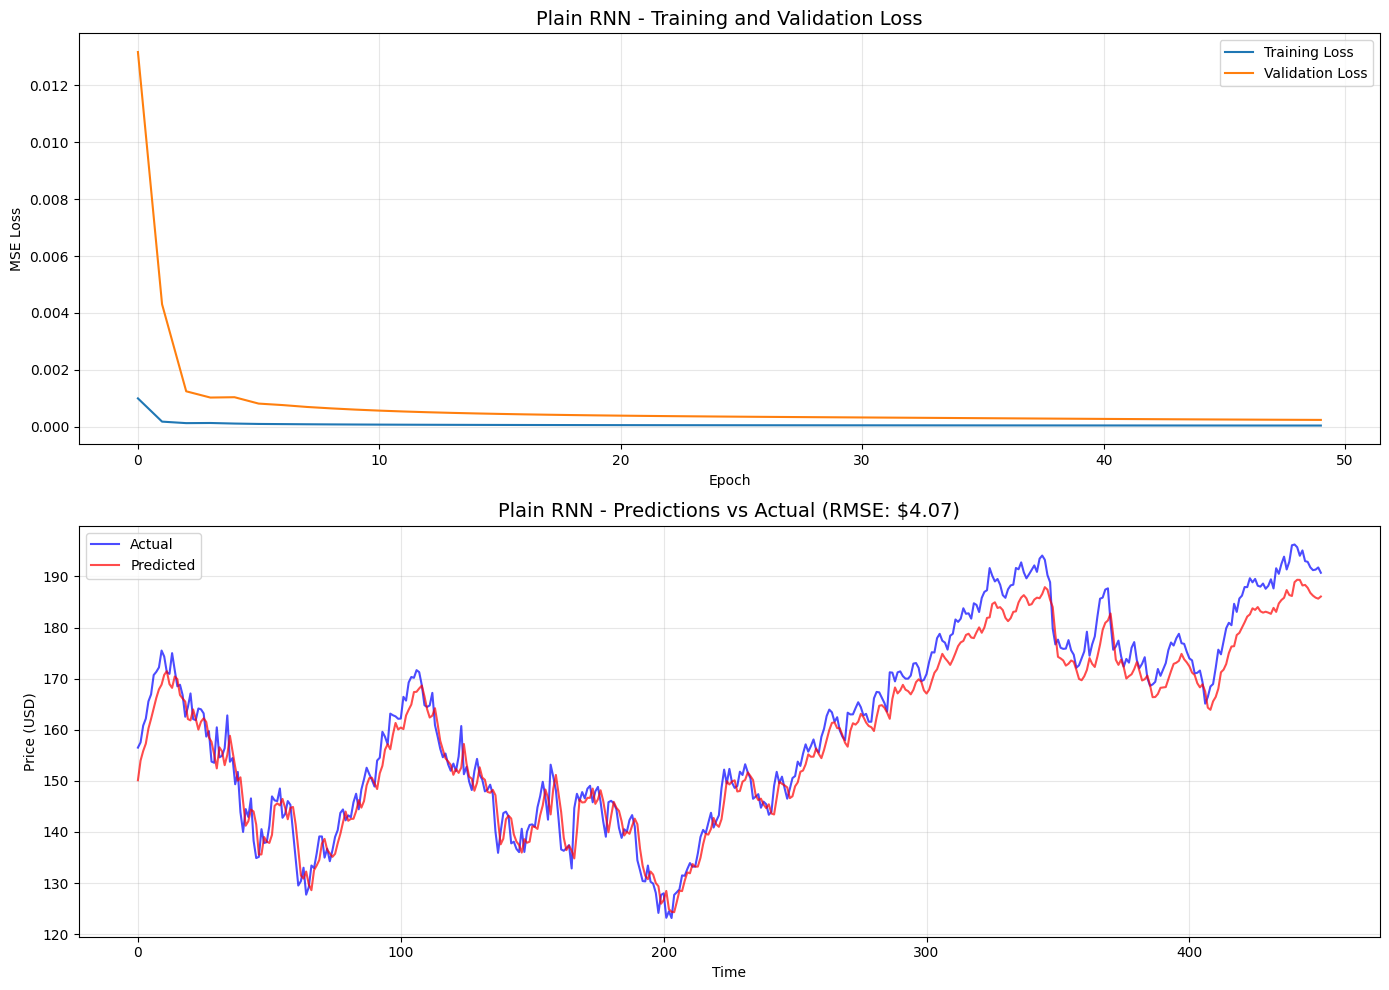

In [ ]:
# Visualize predictions vs actual values
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Training loss
axes[0].plot(history_rnn.history["loss"], label="Training Loss")
axes[0].plot(history_rnn.history["val_loss"], label="Validation Loss")
axes[0].set_title("Plain RNN - Training and Validation Loss", fontsize=14)
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("MSE Loss")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Predictions vs Actual
axes[1].plot(y_test_actual, label="Actual", color="blue", alpha=0.7)
axes[1].plot(y_pred_rnn_actual, label="Predicted", color="red", alpha=0.7)
axes[1].set_title(
    f"Plain RNN - Predictions vs Actual (RMSE: ${rmse_rnn:.2f})", fontsize=14
)
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Price (USD)")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## Task 4: Building a 1D Convolutional Model

- Build a 1D CNN model with Conv1D, MaxPooling1D, Flatten, and Dense layers
- Train and evaluate performance
- Compare results with the plain RNN model


In [17]:
# Build the 1D CNN Model
cnn_model = keras.Sequential(
    [
        layers.Conv1D(
            filters=5, kernel_size=5, activation="relu", input_shape=(lookback, 1)
        ),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dense(1, activation="linear"),
    ],
    name="Conv1D_Model",
)

# Compile the model
cnn_model.compile(optimizer="adam", loss="mse")

# Model summary
cnn_model.summary()

Model: "Conv1D_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 6, 5)           │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 3, 5)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46 (184.00 B)

 Trainable params: 46 (184.00 B)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Train the 1D CNN model
history_cnn = cnn_model.fit(
    X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1
)

Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0228 - val_loss: 0.1273
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0045 - val_loss: 0.0438
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019 - val_loss: 0.0113
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.2818e-04 - val_loss: 0.0014
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6279e-04 - val_loss: 4.6884e-04
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1781e-04 - val_loss: 4.5745e-04
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1361e-04 - val_loss: 4.5653e-04
Epoch 8/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1211e-04 - val_loss: 4.5212e-04
Epoch 9/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1103e-04 - val_loss: 4.4896e-04
Epoch 10/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1026e-04 - val_loss: 4.4643e-04
Epoch 11/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0953e-04 - val_loss: 4.4458e-04
Epoch 12/50
4

In [19]:
# Evaluate the 1D CNN model
y_pred_cnn = cnn_model.predict(X_test)

# Inverse transform to get actual prices
y_pred_cnn_actual = scaler.inverse_transform(y_pred_cnn)

# Calculate RMSE
rmse_cnn = np.sqrt(mean_squared_error(y_test_actual, y_pred_cnn_actual))
print(f"\n1D CNN Model - RMSE: ${rmse_cnn:.2f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

1D CNN Model - RMSE: $4.96


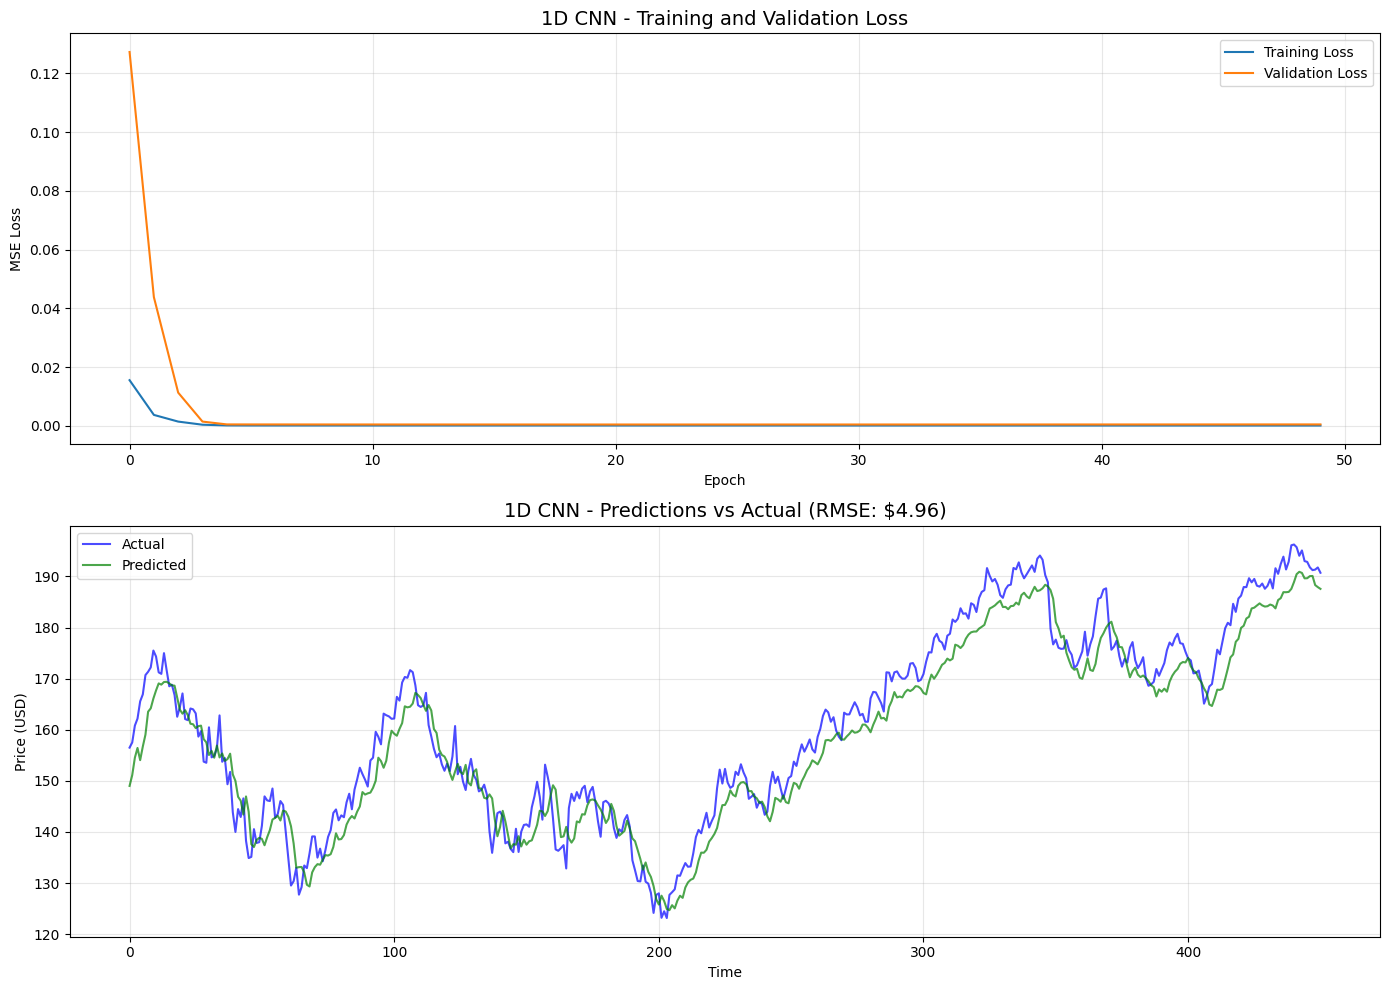

In [ ]:
# Visualize 1D CNN predictions
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Training loss
axes[0].plot(history_cnn.history["loss"], label="Training Loss")
axes[0].plot(history_cnn.history["val_loss"], label="Validation Loss")
axes[0].set_title("1D CNN - Training and Validation Loss", fontsize=14)
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("MSE Loss")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Predictions vs Actual
axes[1].plot(y_test_actual, label="Actual", color="blue", alpha=0.7)
axes[1].plot(y_pred_cnn_actual, label="Predicted", color="green", alpha=0.7)
axes[1].set_title(
    f"1D CNN - Predictions vs Actual (RMSE: ${rmse_cnn:.2f})", fontsize=14
)
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Price (USD)")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [21]:
# Compare RNN vs 1D CNN
print("=" * 60)
print("COMPARISON: Plain RNN vs 1D CNN (AAPL)")
print("=" * 60)
print(f"Plain RNN RMSE: ${rmse_rnn:.2f}")
print(f"1D CNN RMSE:    ${rmse_cnn:.2f}")
if rmse_cnn < rmse_rnn:
    print(f"\n1D CNN performs better by ${rmse_rnn - rmse_cnn:.2f}")
else:
    print(f"\nPlain RNN performs better by ${rmse_cnn - rmse_rnn:.2f}")

COMPARISON: Plain RNN vs 1D CNN (AAPL)
Plain RNN RMSE: $4.07
1D CNN RMSE:    $4.96

Plain RNN performs better by $0.89


---

## Task 5: Building a Hybrid (1D CNN + RNN) Model

- Combine 1D convolutions and RNNs in a single model
- Start with Conv1D, add SimpleRNN, end with Dense output
- Train and evaluate the hybrid model
- Compare performance with previous models


In [22]:
# Build the Hybrid (1D CNN + RNN) Model
hybrid_model = keras.Sequential(
    [
        layers.Conv1D(
            filters=5, kernel_size=3, activation="relu", input_shape=(lookback, 1)
        ),
        layers.SimpleRNN(32, activation="tanh"),
        layers.Dense(1, activation="linear"),
    ],
    name="Hybrid_CNN_RNN_Model",
)

# Compile the model
hybrid_model.compile(optimizer="adam", loss="mse")

# Model summary
hybrid_model.summary()

Model: "Hybrid_CNN_RNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 8, 5)           │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 32)             │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,269 (4.96 KB)

 Trainable params: 1,269 (4.96 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Train the Hybrid model
history_hybrid = hybrid_model.fit(
    X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1
)

Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0101 - val_loss: 0.0132
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.6451e-04 - val_loss: 0.0085
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0060e-04 - val_loss: 0.0068
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7502e-04 - val_loss: 0.0053
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.5164e-04 - val_loss: 0.0040
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.3050e-04 - val_loss: 0.0029
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0993e-04 - val_loss: 0.0025
Epoch 8/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9288e-04 - val_loss: 0.0025
Epoch 9/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8296e-04 - val_loss: 0.0026
Epoch 10/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7630e-04 - val_loss: 0.0026
Epoch 11/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6838e-04 - val_loss: 0.0024
Epoch 12/50
46/46 ━━━━━━━━━━━━━━━

In [24]:
# Evaluate the Hybrid model
y_pred_hybrid = hybrid_model.predict(X_test)

# Inverse transform to get actual prices
y_pred_hybrid_actual = scaler.inverse_transform(y_pred_hybrid)

# Calculate RMSE
rmse_hybrid = np.sqrt(mean_squared_error(y_test_actual, y_pred_hybrid_actual))
print(f"\nHybrid Model - RMSE: ${rmse_hybrid:.2f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step

Hybrid Model - RMSE: $4.63


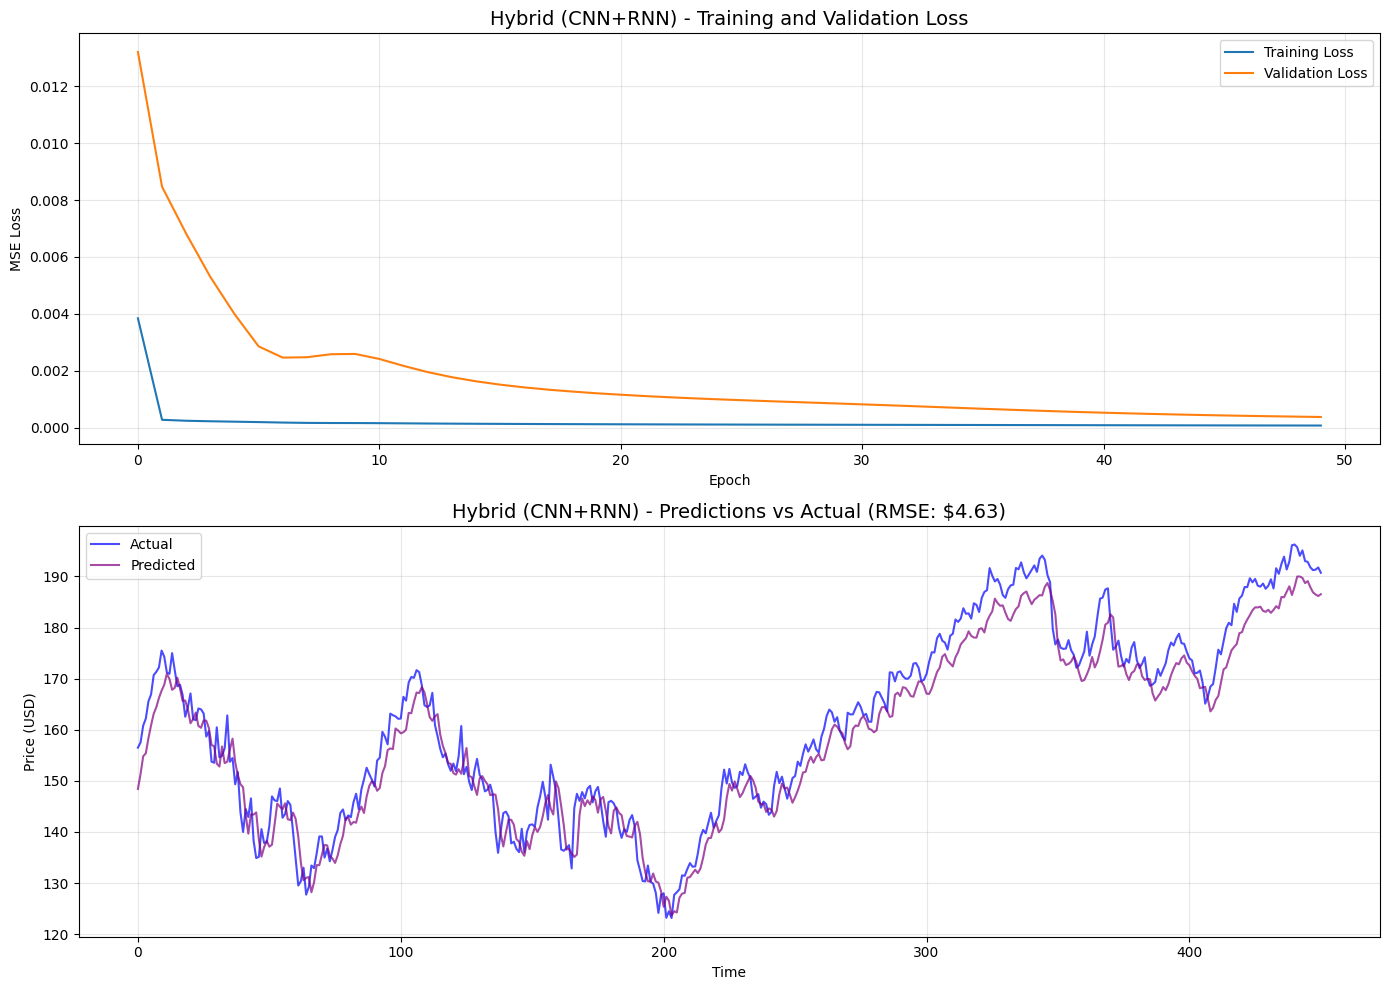

In [ ]:
# Visualize Hybrid model predictions
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Training loss
axes[0].plot(history_hybrid.history["loss"], label="Training Loss")
axes[0].plot(history_hybrid.history["val_loss"], label="Validation Loss")
axes[0].set_title("Hybrid (CNN+RNN) - Training and Validation Loss", fontsize=14)
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("MSE Loss")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Predictions vs Actual
axes[1].plot(y_test_actual, label="Actual", color="blue", alpha=0.7)
axes[1].plot(y_pred_hybrid_actual, label="Predicted", color="purple", alpha=0.7)
axes[1].set_title(
    f"Hybrid (CNN+RNN) - Predictions vs Actual (RMSE: ${rmse_hybrid:.2f})", fontsize=14
)
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Price (USD)")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [26]:
# Compare all three models
print("=" * 60)
print("COMPARISON: All Models (AAPL)")
print("=" * 60)
results_aapl = {
    "Model": ["Plain RNN", "1D CNN", "Hybrid (CNN+RNN)"],
    "RMSE": [rmse_rnn, rmse_cnn, rmse_hybrid],
}
results_df = pd.DataFrame(results_aapl)
results_df = results_df.sort_values("RMSE").reset_index(drop=True)
print(results_df.to_string(index=False))
print(
    f"\nBest model: {results_df.iloc[0]['Model']} with RMSE: ${results_df.iloc[0]['RMSE']:.2f}"
)

COMPARISON: All Models (AAPL)
           Model     RMSE
       Plain RNN 4.071055
Hybrid (CNN+RNN) 4.626182
          1D CNN 4.960417

Best model: Plain RNN with RMSE: $4.07


---

## Task 6: Activity – Predicting IBM Stock Prices

- Load and visualize IBM stock price data
- Split data into train/test sets (75%/25%)
- Scale the data using MinMaxScaler
- Create lookback sequences (lookback = 15)
- Build a hybrid model with dropout for regularization
- Train the model and evaluate using RMSE
- Plot predictions vs actual values (full and zoomed-in views)


In [27]:
# Load IBM stock price data
try:
    import yfinance as yf

    ibm = yf.download("IBM", start="2015-01-01", end="2024-01-01", progress=False)
    ibm.to_csv("IBM.csv")
    print("IBM data downloaded successfully from Yahoo Finance")
except:
    ibm = pd.read_csv("IBM.csv", index_col="Date", parse_dates=True)
    print("IBM data loaded from CSV file")

print(f"\nDataset Shape: {ibm.shape}")
print(f"\nFirst 5 rows:")
ibm.head()

IBM data downloaded successfully from Yahoo Finance

Dataset Shape: (2264, 5)

First 5 rows:


Price,Close,High,Low,Open,Volume
Ticker,IBM,IBM,IBM,IBM,IBM
Date,,,,,
2015-01-02,98.123055,98.879902,97.481254,97.668954,5779673
2015-01-05,96.579094,97.644728,96.385345,97.644728,5104898
2015-01-06,94.496262,96.851556,93.951340,96.675965,6429448
2015-01-07,93.878662,95.180431,93.261079,95.180431,4918083
2015-01-08,95.919121,96.294510,94.181409,94.599184,4431693


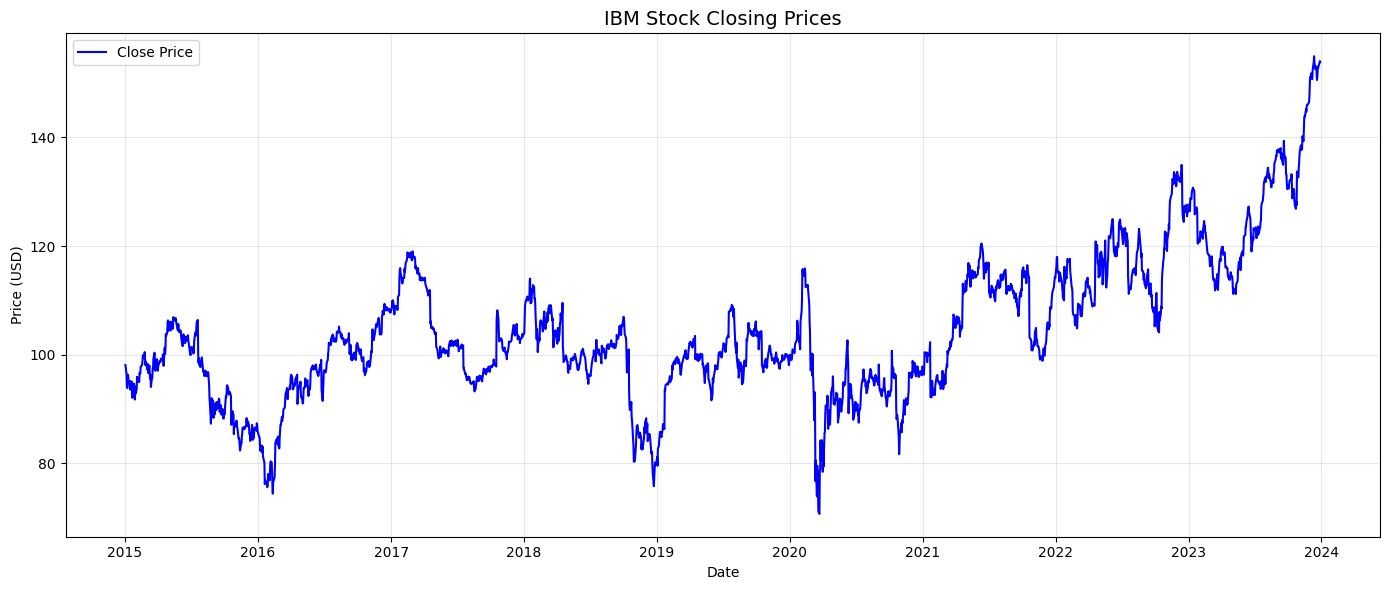

In [28]:
# Visualize IBM stock price trends
plt.figure(figsize=(14, 6))
plt.plot(ibm["Close"], label="Close Price", color="blue")
plt.title("IBM Stock Closing Prices", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [29]:
# Extract closing prices
ibm_close = ibm["Close"].values.reshape(-1, 1)

# Scale the data using MinMaxScaler
scaler_ibm = MinMaxScaler(feature_range=(0, 1))
ibm_scaled = scaler_ibm.fit_transform(ibm_close)

# Define lookback period
lookback_ibm = 15

# Create sequences
X_ibm, y_ibm = create_sequences(ibm_scaled, lookback_ibm)

# Split into train/test sets (75%/25%)
split_idx_ibm = int(len(X_ibm) * 0.75)
X_train_ibm, X_test_ibm = X_ibm[:split_idx_ibm], X_ibm[split_idx_ibm:]
y_train_ibm, y_test_ibm = y_ibm[:split_idx_ibm], y_ibm[split_idx_ibm:]

print(f"IBM Dataset:")
print(f"Lookback period: {lookback_ibm}")
print(f"X_train shape: {X_train_ibm.shape}")
print(f"y_train shape: {y_train_ibm.shape}")
print(f"X_test shape: {X_test_ibm.shape}")
print(f"y_test shape: {y_test_ibm.shape}")

IBM Dataset:
Lookback period: 15
X_train shape: (1686, 15, 1)
y_train shape: (1686, 1)
X_test shape: (563, 15, 1)
y_test shape: (563, 1)


In [30]:
# Build a Hybrid Model with Dropout for IBM
ibm_hybrid_model = keras.Sequential(
    [
        layers.Conv1D(
            filters=32, kernel_size=3, activation="relu", input_shape=(lookback_ibm, 1)
        ),
        layers.Dropout(0.2),
        layers.SimpleRNN(64, activation="tanh", return_sequences=True),
        layers.Dropout(0.2),
        layers.SimpleRNN(32, activation="tanh"),
        layers.Dropout(0.2),
        layers.Dense(16, activation="relu"),
        layers.Dense(1, activation="linear"),
    ],
    name="IBM_Hybrid_Model_with_Dropout",
)

# Compile the model
ibm_hybrid_model.compile(optimizer="adam", loss="mse")

# Model summary
ibm_hybrid_model.summary()

Model: "IBM_Hybrid_Model_with_Dropout"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 13, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 13, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 13, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 13, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_4 (SimpleRNN)        │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,985 (39.00 KB)

 Trainable params: 9,985 (39.00 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Train the IBM Hybrid model
history_ibm = ibm_hybrid_model.fit(
    X_train_ibm, y_train_ibm, epochs=100, batch_size=32, validation_split=0.2, verbose=1
)

Epoch 1/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - loss: 0.0741 - val_loss: 0.0091
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0163 - val_loss: 0.0017
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0083 - val_loss: 0.0019
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0070 - val_loss: 0.0019
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0056 - val_loss: 0.0024
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0038 - val_loss: 0.0014
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0038 - val_loss: 0.0014
Epoch 8/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032 - val_loss: 0.0015
Epoch 9/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032 - val_loss: 0.0019
Epoch 10/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - val_loss: 0.0016
Epoch 11/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024 - val_loss: 0.0014
Epoch 12/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 

In [32]:
# Evaluate the IBM model
y_pred_ibm = ibm_hybrid_model.predict(X_test_ibm)

# Inverse transform to get actual prices
y_test_ibm_actual = scaler_ibm.inverse_transform(y_test_ibm)
y_pred_ibm_actual = scaler_ibm.inverse_transform(y_pred_ibm)

# Calculate RMSE
rmse_ibm = np.sqrt(mean_squared_error(y_test_ibm_actual, y_pred_ibm_actual))
print(f"\nIBM Hybrid Model with Dropout - RMSE: ${rmse_ibm:.2f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step

IBM Hybrid Model with Dropout - RMSE: $4.28


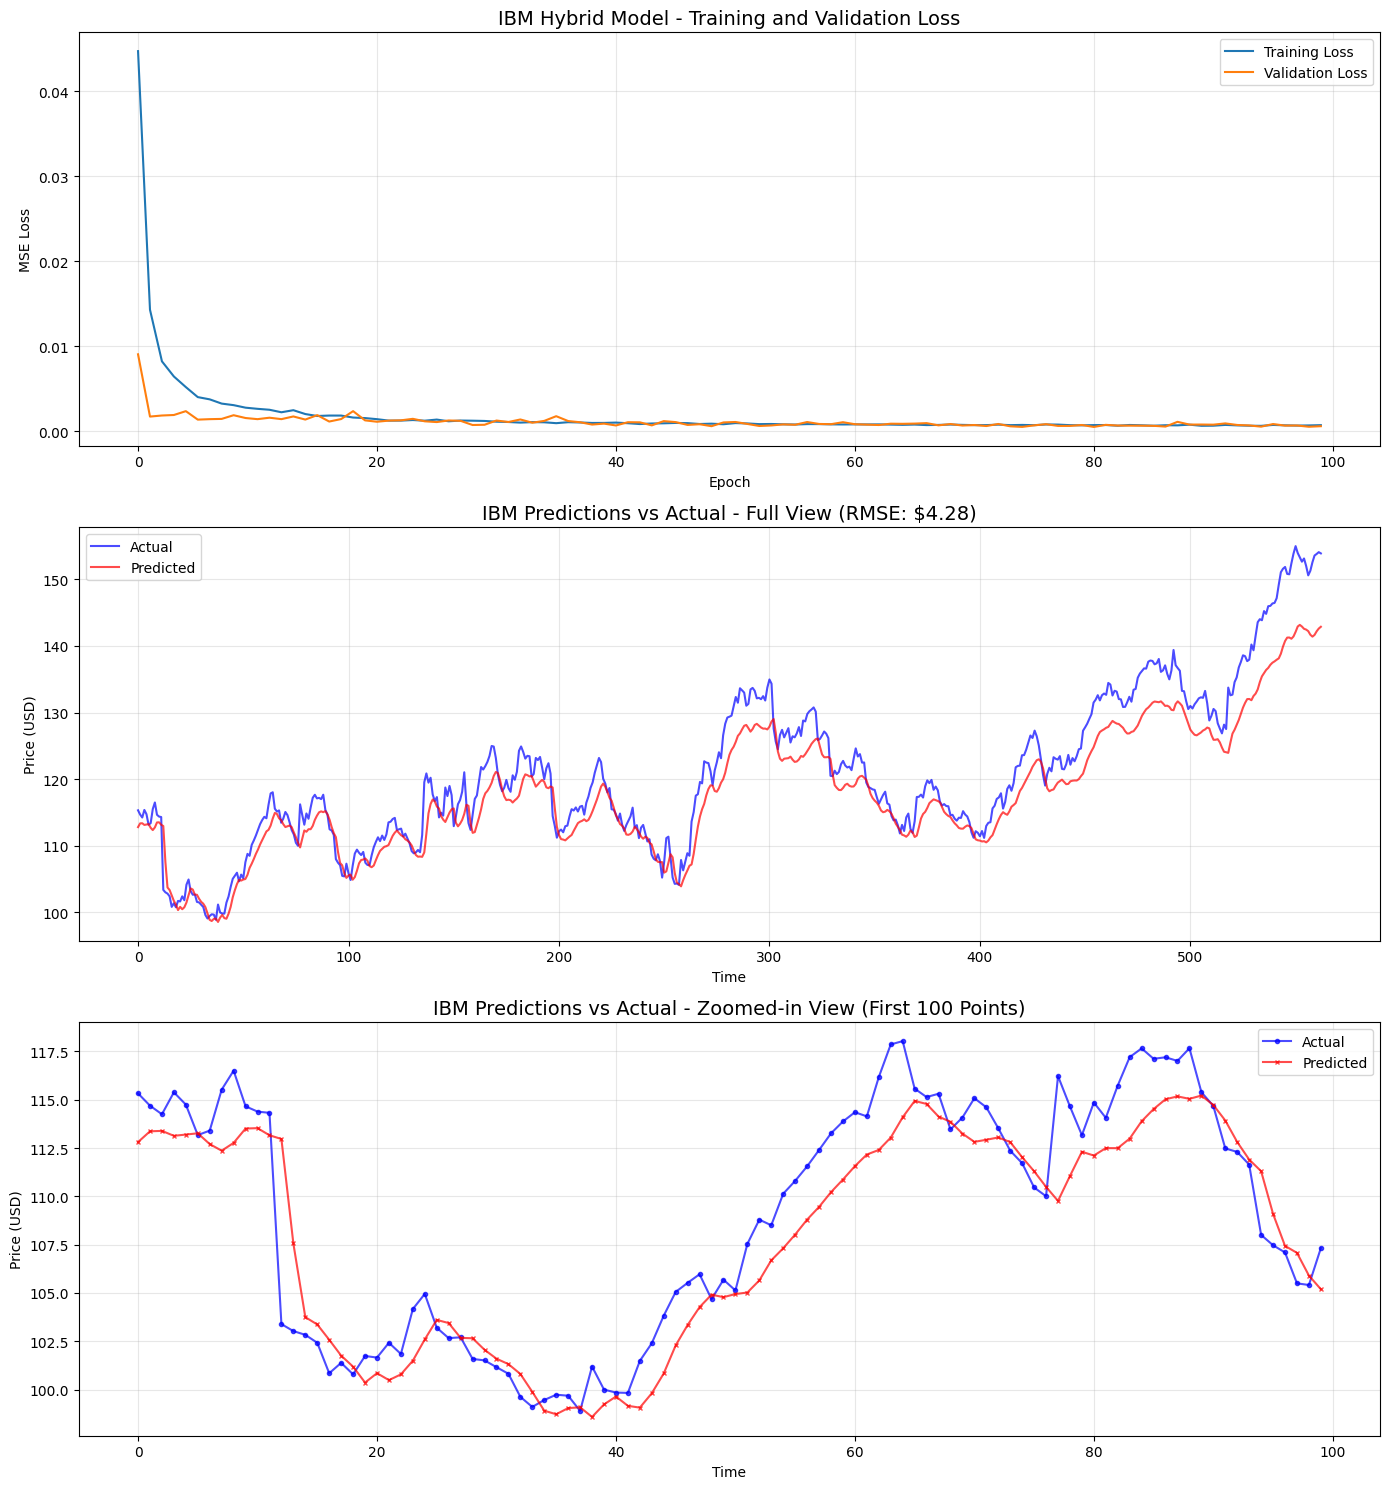

In [ ]:
# Plot predictions vs actual values - Full view
fig, axes = plt.subplots(3, 1, figsize=(14, 15))

# Training loss
axes[0].plot(history_ibm.history["loss"], label="Training Loss")
axes[0].plot(history_ibm.history["val_loss"], label="Validation Loss")
axes[0].set_title("IBM Hybrid Model - Training and Validation Loss", fontsize=14)
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("MSE Loss")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Full predictions vs Actual
axes[1].plot(y_test_ibm_actual, label="Actual", color="blue", alpha=0.7)
axes[1].plot(y_pred_ibm_actual, label="Predicted", color="red", alpha=0.7)
axes[1].set_title(
    f"IBM Predictions vs Actual - Full View (RMSE: ${rmse_ibm:.2f})", fontsize=14
)
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Price (USD)")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Zoomed-in view (first 100 points)
zoom_range = min(100, len(y_test_ibm_actual))
axes[2].plot(
    y_test_ibm_actual[:zoom_range],
    label="Actual",
    color="blue",
    alpha=0.7,
    marker="o",
    markersize=3,
)
axes[2].plot(
    y_pred_ibm_actual[:zoom_range],
    label="Predicted",
    color="red",
    alpha=0.7,
    marker="x",
    markersize=3,
)
axes[2].set_title(
    "IBM Predictions vs Actual - Zoomed-in View (First 100 Points)", fontsize=14
)
axes[2].set_xlabel("Time")
axes[2].set_ylabel("Price (USD)")
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## Summary and Model Comparison


In [34]:
# Final comparison of all models
print("=" * 70)
print("FINAL MODEL COMPARISON")
print("=" * 70)

print("\n--- AAPL Stock Price Prediction ---")
print(f"Plain RNN Model RMSE:           ${rmse_rnn:.2f}")
print(f"1D CNN Model RMSE:              ${rmse_cnn:.2f}")
print(f"Hybrid (CNN+RNN) Model RMSE:    ${rmse_hybrid:.2f}")

print("\n--- IBM Stock Price Prediction ---")
print(f"Hybrid Model with Dropout RMSE: ${rmse_ibm:.2f}")

print("\n" + "=" * 70)
print("BRIEF COMPARISON ANALYSIS")
print("=" * 70)
print(
    """
1. Plain RNN Model:
   - Simplest architecture with basic sequential memory
   - Good baseline performance
   - May struggle with long-term dependencies

2. 1D CNN Model:
   - Extracts local patterns from time series
   - Faster to train than RNNs
   - May miss long-term sequential dependencies

3. Hybrid (CNN + RNN) Model:
   - Combines advantages of both CNN and RNN
   - CNN extracts local features
   - RNN captures temporal dependencies
   - Often achieves best performance

4. Hybrid with Dropout (IBM Model):
   - Includes regularization to prevent overfitting
   - Multiple RNN layers for deeper temporal learning
   - Generally more robust for complex patterns

Key Observations:
- The hybrid architecture typically outperforms single-architecture models
- Dropout helps regularize the model and improve generalization
- Lookback period affects model performance significantly
- Stock price prediction is inherently challenging due to market volatility
"""
)

FINAL MODEL COMPARISON

--- AAPL Stock Price Prediction ---
Plain RNN Model RMSE:           $4.07
1D CNN Model RMSE:              $4.96
Hybrid (CNN+RNN) Model RMSE:    $4.63

--- IBM Stock Price Prediction ---
Hybrid Model with Dropout RMSE: $4.28

BRIEF COMPARISON ANALYSIS

1. Plain RNN Model:
   - Simplest architecture with basic sequential memory
   - Good baseline performance
   - May struggle with long-term dependencies

2. 1D CNN Model:
   - Extracts local patterns from time series
   - Faster to train than RNNs
   - May miss long-term sequential dependencies

3. Hybrid (CNN + RNN) Model:
   - Combines advantages of both CNN and RNN
   - CNN extracts local features
   - RNN captures temporal dependencies
   - Often achieves best performance

4. Hybrid with Dropout (IBM Model):
   - Includes regularization to prevent overfitting
   - Multiple RNN layers for deeper temporal learning
   - Generally more robust for complex patterns

Key Observations:
- The hybrid architecture typical

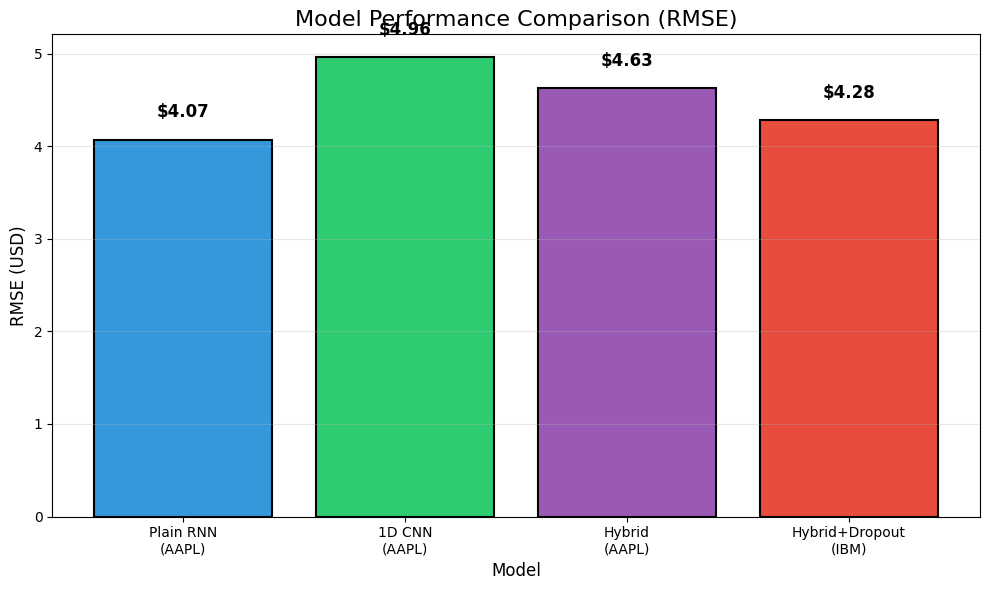

In [35]:
# Create a bar chart comparing RMSE values
plt.figure(figsize=(10, 6))

models = [
    "Plain RNN\n(AAPL)",
    "1D CNN\n(AAPL)",
    "Hybrid\n(AAPL)",
    "Hybrid+Dropout\n(IBM)",
]
rmse_values = [rmse_rnn, rmse_cnn, rmse_hybrid, rmse_ibm]
colors = ["#3498db", "#2ecc71", "#9b59b6", "#e74c3c"]

bars = plt.bar(models, rmse_values, color=colors, edgecolor="black", linewidth=1.5)

# Add value labels on bars
for bar, rmse in zip(bars, rmse_values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.2,
        f"${rmse:.2f}",
        ha="center",
        va="bottom",
        fontsize=12,
        fontweight="bold",
    )

plt.title("Model Performance Comparison (RMSE)", fontsize=16)
plt.ylabel("RMSE (USD)", fontsize=12)
plt.xlabel("Model", fontsize=12)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()